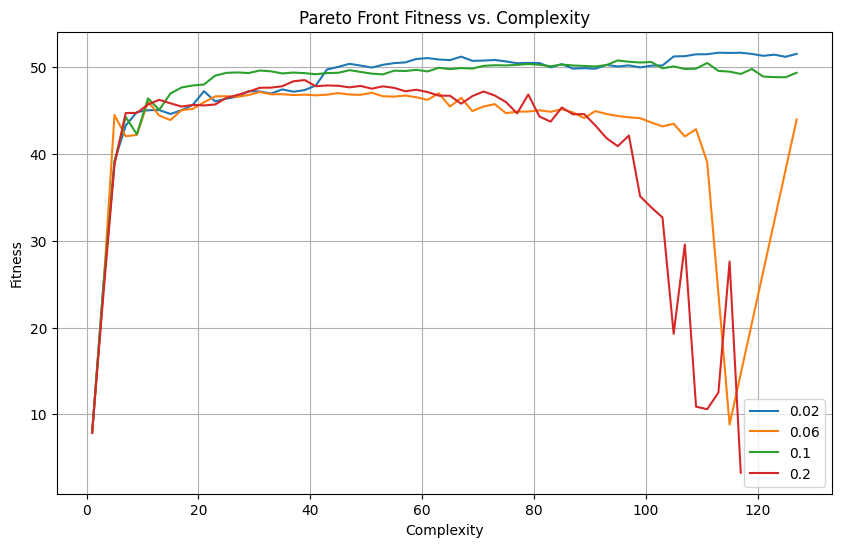

In [39]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

exp1 = ["20250409_120706", "0.02"]
exp2 = ["20250409_120719", "0.06"]
exp3 = ["20250409_120749", "0.1"]
exp4 = ["20250409_120758", "0.2"]

def get_valid_data(file_name):

    with open(file_name + ".pkl", "rb") as f:
        pareto_front = pickle.load(f)

    fitness = pareto_front.fitness.cpu()
    complexity = np.arange(len(fitness))

    valid_complexity = []
    valid_fitness = []
    for c, f in zip(complexity, fitness):
        if f > 0 and c > 0 and c < 256:
            valid_complexity.append(c)
            valid_fitness.append(f)

    return valid_complexity, valid_fitness


x_1, y_1 = get_valid_data("data/results/" + exp1[0])
x_2, y_2 = get_valid_data("data/results/" + exp2[0])
x_3, y_3 = get_valid_data("data/results/" + exp3[0])
x_4, y_4 = get_valid_data("data/results/" + exp4[0])

# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot(x_1, y_1, label=exp1[1])
plt.plot(x_2, y_2, label=exp2[1])
plt.plot(x_3, y_3, label=exp3[1])
plt.plot(x_4, y_4, label=exp4[1])
plt.xlabel("Complexity")
plt.ylabel("Fitness")
plt.title("Pareto Front Fitness vs. Complexity")
plt.grid(True)
plt.legend()
plt.show()

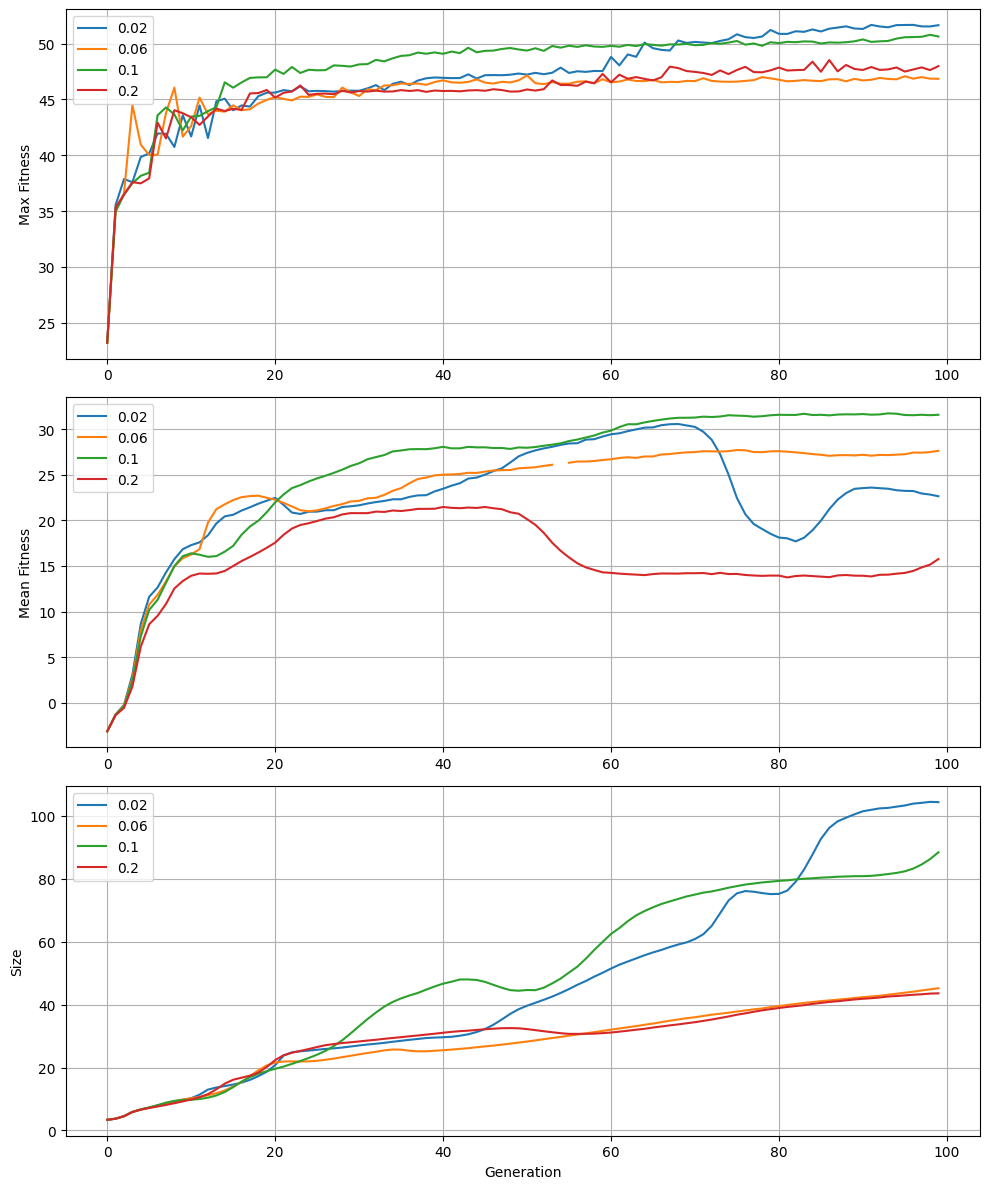

In [41]:
import matplotlib.pyplot as plt
import pandas as pd


def read_columns_with_pandas(file_name):
    df = pd.read_csv(file_name + ".csv")
    return {col: df[col].tolist() for col in df.columns}


data1 = read_columns_with_pandas("data/results/" + exp1[0])
data2 = read_columns_with_pandas("data/results/" + exp2[0])
data3 = read_columns_with_pandas("data/results/" + exp3[0])
data4 = read_columns_with_pandas("data/results/" + exp4[0])
gen = 100

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(data1["generation"][:gen], data1["best_fitness"][:gen], label=exp1[1])
plt.plot(data2["generation"][:gen], data2["best_fitness"][:gen], label=exp2[1])
plt.plot(data3["generation"][:gen], data3["best_fitness"][:gen], label=exp3[1])
plt.plot(data4["generation"][:gen], data4["best_fitness"][:gen], label=exp4[1])
plt.ylabel("Max Fitness")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(data1["generation"][:gen], data1["mean_fitness"][:gen], label=exp1[1])
plt.plot(data2["generation"][:gen], data2["mean_fitness"][:gen], label=exp2[1])
plt.plot(data3["generation"][:gen], data3["mean_fitness"][:gen], label=exp3[1])
plt.plot(data4["generation"][:gen], data4["mean_fitness"][:gen], label=exp4[1])
plt.ylabel("Mean Fitness")
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(data1["generation"][:gen], data1["mean_tree_size"][:gen], label=exp1[1])
plt.plot(data2["generation"][:gen], data2["mean_tree_size"][:gen], label=exp2[1])
plt.plot(data3["generation"][:gen], data3["mean_tree_size"][:gen], label=exp3[1])
plt.plot(data4["generation"][:gen], data4["mean_tree_size"][:gen], label=exp4[1])
plt.xlabel("Generation")
plt.ylabel("Size")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()